# Mapping sensor level measurements to source level brain activity

Given $Seeg(t)=G*X(t)$, where $Seeg(t)$ is sensor level measurement at time $t$,  we aim to estimate the source brain activity $X(t)$ by Moore-Penrose inversion of gain matrix $G$.

In [1]:
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
%pylab inline

plt.style.use('seaborn-paper');

Populating the interactive namespace from numpy and matplotlib


In [4]:
from numpy.linalg import matrix_rank

In [5]:
cwd = os.getcwd()
cwd

'/home/meysam/BVEP/MainCodesBVEPmodel'

Here, we plot the simulated seeg signnals.

In [6]:
synthetic_data=np.load(cwd+'/DataOutput_TVB/Syntheticdata_CJ_Config2_SDE.npz')

In [7]:
Ez_idx=[6, 34]
Pz_idx=[5, 11, 27]

In [8]:
Seeg=synthetic_data['Seeg_Gr_lin'].T
G=synthetic_data['Gr']
X=synthetic_data['X'].T

In [9]:
Seeg.shape, G.shape, X.shape

((162, 10000), (162, 84), (84, 10000))

In [10]:
nn=int(X.shape[0])
nt=int(X.shape[1])
ns=int(Seeg.shape[0])

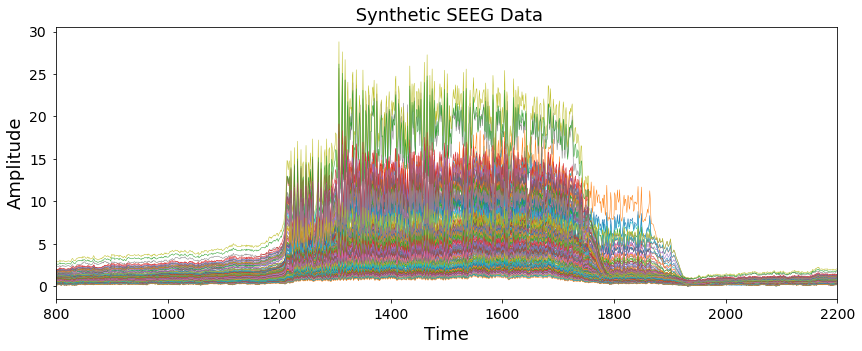

In [98]:
plt.figure(figsize=(14, 5))
for i in range(ns):
    plt.plot( 1e-1*Seeg[i, :]-min(1e-1*Seeg[i, :]), lw=0.5)
plt.xlim([800, 2200])    
plt.xlabel("Time", fontsize=18)
plt.ylabel("Amplitude", fontsize=18)
plt.title(' Synthetic SEEG Data', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig(os.path.join(cwd,"SimulatedSeeg.png"))
plt.show() 

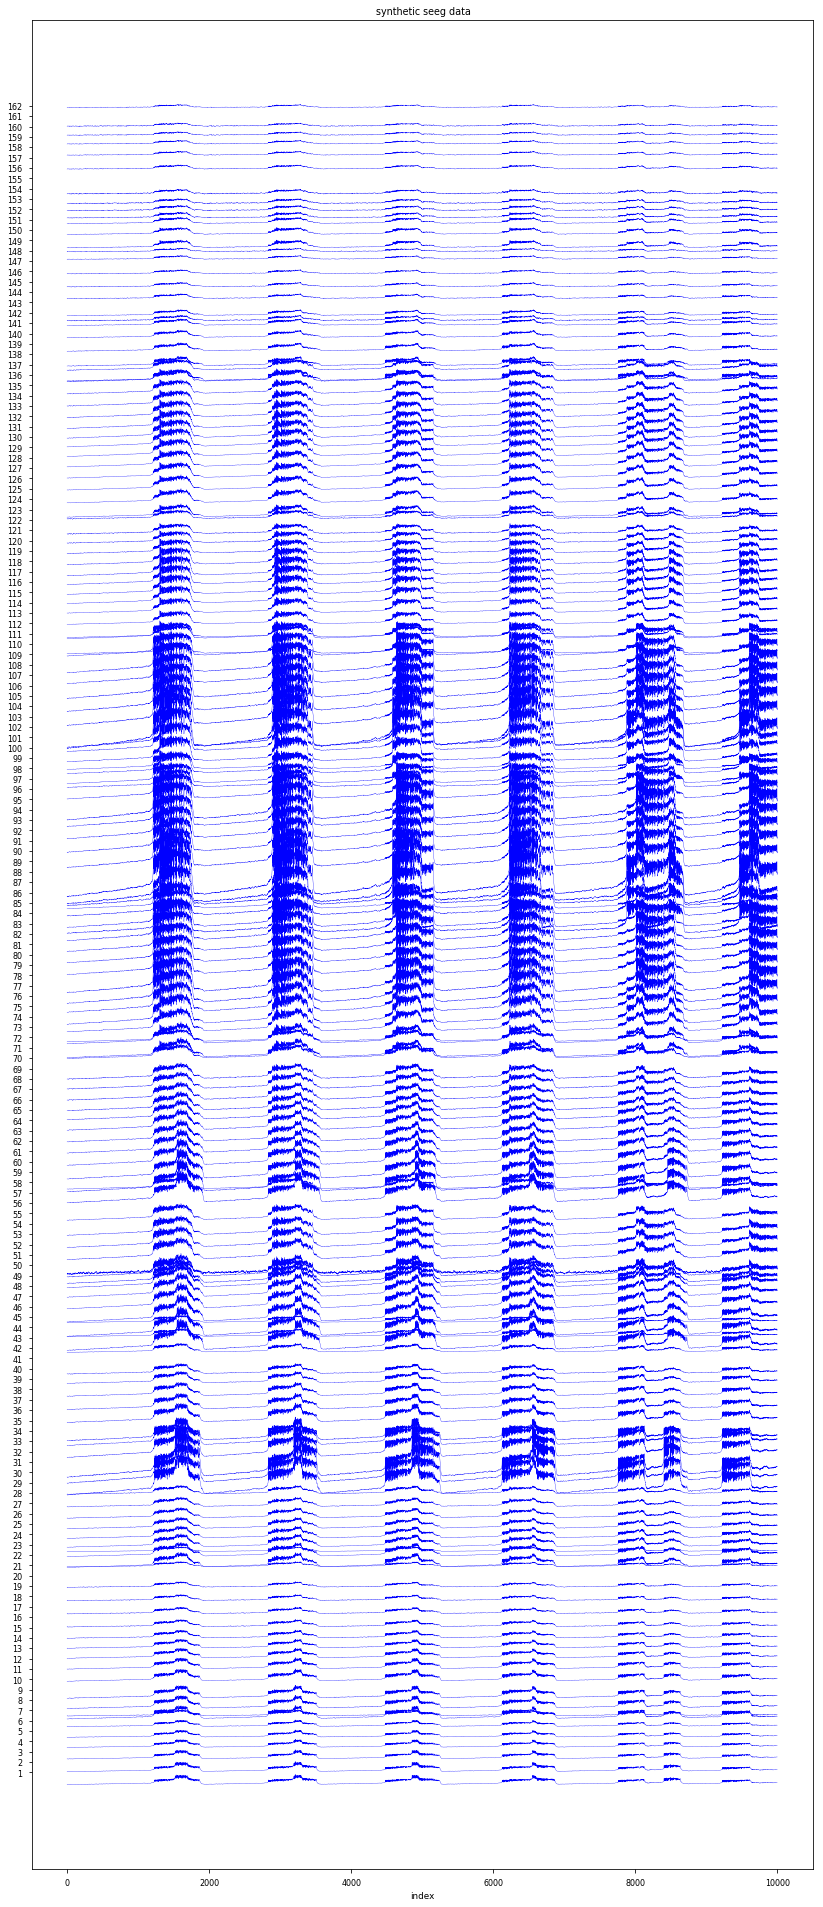

In [11]:
plt.figure(figsize=(14, 34))
for i in range(ns):
    plt.plot( 1e-1*Seeg[i, :] + 4*i, 'b', lw=0.3)
plt.xlabel("index")
plt.yticks(4*(np.r_[:ns]-4), np.r_[:ns]+1)
plt.title(' synthetic seeg data')
plt.show() 

we can define the Moore-Penrose or generalized inversion (g-inverse) as follows:

Given a rectangular matrix G with dimentio $n\times m$, matrix $G^{-}$ is said to be a generalized inverse (Moore-Penrose inverse) of G if:  $GG^{-}G=G$. 

The generalized inverse is defined as the matrix $G^{-}$ such that

$GG^{-}G=G$ and $G^{-}GG^{-}=G^{-}$. 

Note that both $GG^{-}$ and $G^{-}G$ are symmetric, but neither product gives an identity matrix.


Given $S(t)=G*X(t)$, where the rectangular matrix S(t) with dimention $ns \times nt$ is sensor level measuremenets at time t, matrix G with dimention $ns \times nn$ is gain matrix, and X(t) represents the source brain activity at time t with dimention $nn \times nt$.


$  (S-GX)^T (S-GX) | \underset {\min_{x_1,\dots x_{nt}} \displaystyle} =0$, so:

$\dfrac{d}{dX} ((S-GX)^T (S-GX))=0$,

yields:


$X=(G^TG)^{-} G^TS$.


Here $(G^TG)^{-}$ is g-inverse of $G^TG$:

$QQ^{-}Q=Q, where Q=G^TG$.

The number of observation: $ns \times nt$.

The number of parameters: $nt \times nn$.



In [35]:
S=Seeg+0.001*np.random.randn(ns,nt)


In [36]:
Seeg.shape, G.shape, X.shape

((162, 10000), (162, 84), (84, 10000))

In [37]:
G.shape, matrix_rank(G)

((162, 84), 84)

In [38]:
Q=np.dot(G.T, G)

In [39]:
Q.shape, matrix_rank(Q)

((84, 84), 74)

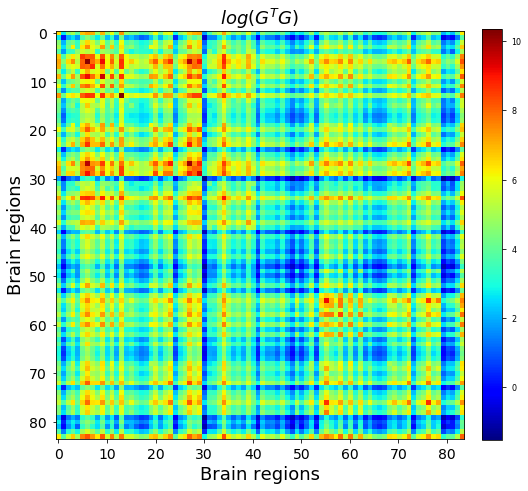

In [49]:
plt.figure(figsize=(8,8))
plt.imshow(np.log(Q),  interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel("Brain regions", fontsize=18)
plt.ylabel("Brain regions", fontsize=18)
plt.title("$log (G^TG)$", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(cwd,"plot_GTG.png"))
plt.show()

Note that pseudo-inverse of matrix Q is sensitive to the level of tolerece, i.e., the cutoff for small singular values. Accordinng to numpy.linalg.pinv¶, the Singular values smaller (in modulus) than rcond * largest_singular_value (again, in modulus) are set to zero.

To get the proper tolerence value, we sweep over rcond using $np.linalg.pinv$, and we then select the min of error between $Q$ and $QQ^{-}Q$, where $Q=G^TG$. 

In [46]:
tol=[]
Errinv=[]
i=0
for e in range(30):
    eps=(10**(-1*e))
    Q_ginv = np.linalg.pinv(Q,  rcond=eps)
    tol.append(10**(-1*e))
    Errinv.append(np.sum((Q- np.dot(Q, np.dot(Q_ginv, Q)))**2))
    i=i=1

In [69]:
np.log(Errinv)[10]

-20.713735263225548

In [47]:
eps_opt = tol[np.argmin(Errinv)]
print('optimal rcond=', eps_opt)

optimal rcond= 1e-10


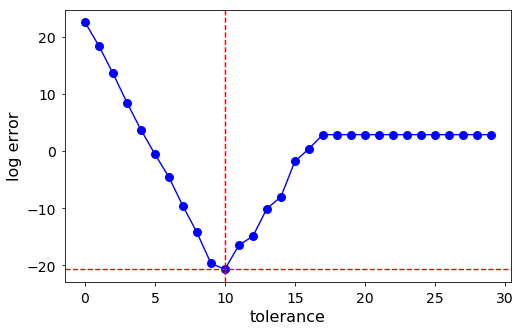

In [99]:
plt.figure(figsize=(8, 5))    
plt.plot(range(30), np.log(Errinv), '.b-', markersize=18)
plt.axvline(x=np.argmin(Errinv),color='red',linestyle='--')
plt.axhline(y=np.log(Errinv)[np.argmin(Errinv)],color='red',linestyle='--')
plt.xlabel("tolerance", fontsize=16)
plt.ylabel("log error", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(cwd,"SweepTol.png"))
plt.show()

so

In [72]:
Q_ginv = np.linalg.pinv(Q,  rcond=eps_opt)

In [73]:
np.allclose(Q, np.dot(Q, np.dot(Q_ginv, Q)))   

True

In [74]:
print('error=', np.sum((Q- np.dot(Q, np.dot(Q_ginv, Q))))**2)

error= 5.920837903381118e-09


In [75]:
X_est=np.dot(np.dot(Q_ginv, G.T), S)

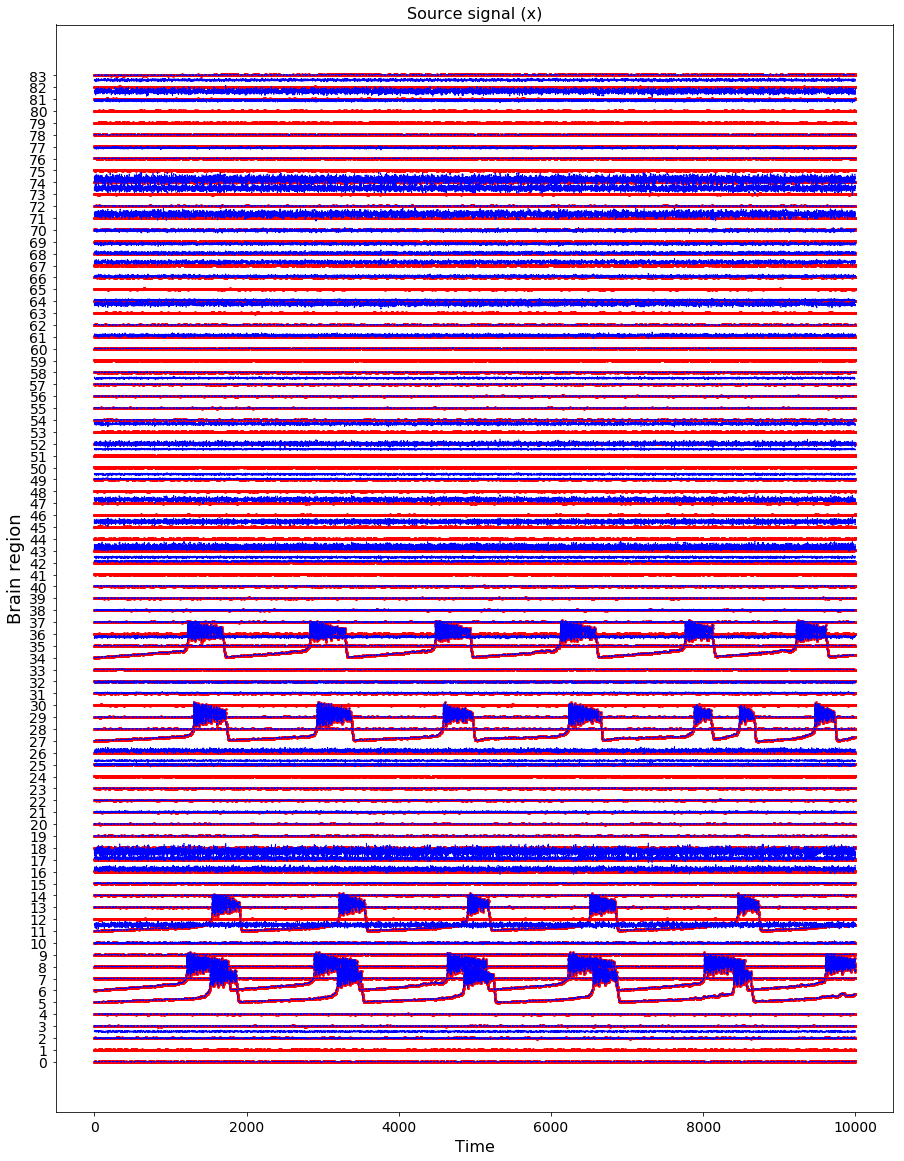

In [78]:
plt.figure(figsize=(15,20))
plt.plot( X.T+ np.r_[0:(nn)]+2, '.r')
plt.plot(X_est.T+ np.r_[0:(nn)]+2, 'b--', linewidth=1)
plt.yticks(np.r_[0:(nn)], np.r_[0:(nn)],fontsize=10)
plt.title("Source signal (x)",fontsize=16)
plt.xlabel('Time',fontsize=16)
plt.ylabel('Brain region',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(cwd,"SourceLocalization.png"))

plt.show()

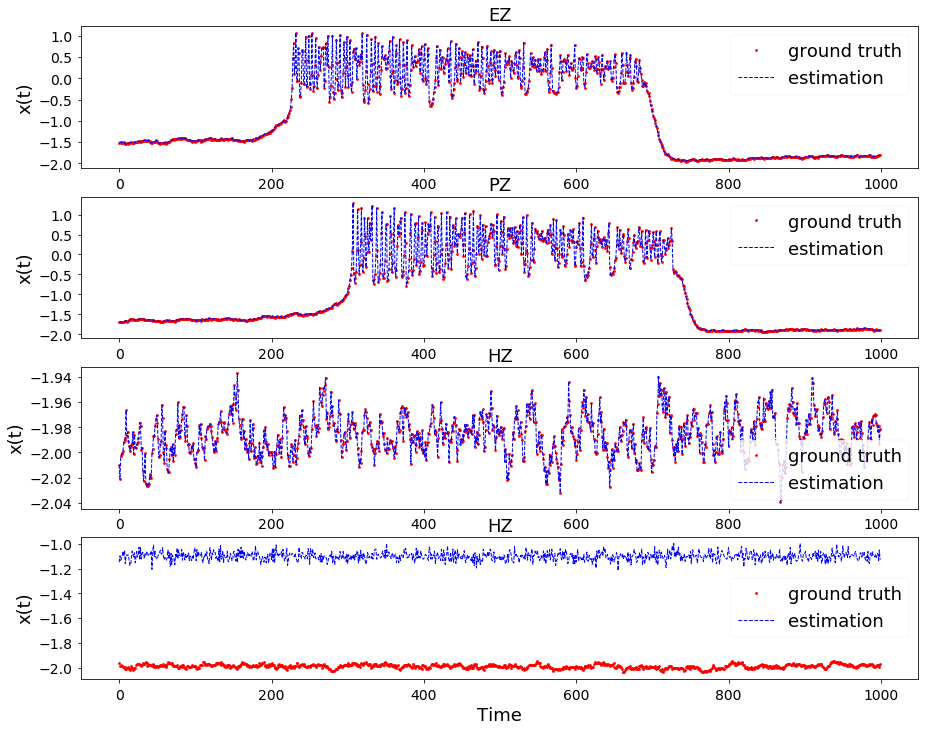

In [80]:
plt.figure(figsize=(15,12))
plt.subplot(4,1,1)
plt.plot(X[Ez_idx[1],1000:2000], '.r', label='ground truth')
plt.plot(X_est[34,1000:2000], 'b--', linewidth=1, label='estimation')
plt.ylabel('x(t)',fontsize=18)
plt.title("EZ",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)

plt.subplot(4,1,2)
plt.plot( X[Pz_idx[2],1000:2000], '.r', label='ground truth')
plt.plot(X_est[27,1000:2000], 'b--', linewidth=1, label='estimation')
plt.ylabel('x(t)',fontsize=18)
plt.title("PZ",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)

plt.subplot(4,1,3)
plt.plot( X[0,1000:2000], '.r', label='ground truth')
plt.plot(X_est[0,1000:2000], 'b--', linewidth=1, label='estimation')
plt.ylabel('x(t)',fontsize=18)
plt.title("HZ",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)

plt.subplot(4,1,4)
plt.plot( X[80,1000:2000], '.r', label='ground truth')
plt.plot(X_est[80,1000:2000], 'b--', linewidth=1, label='estimation')
plt.ylabel('x(t)',fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.title("HZ",fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)

plt.savefig(os.path.join(cwd,"SourceLocalizationEZPZHZ.png"))
plt.show()

In [81]:
Err_per_region= np.sum((X_est-X)**2, axis=1)

In [82]:
print('error in source estimation=', np.sum(Err_per_region))

error in source estimation= 338931.5611849468


Note that error mainly comes from HZ, where (G^TG) is sparse (see the blue-ish in GTG plot).

In [83]:
print('error in source EZ estimation=', Err_per_region[Ez_idx])

error in source EZ estimation= [5.34488088e-06 5.25461290e-03]


In [84]:
print('error in source HZ estimation=', Err_per_region[50])

error in source HZ estimation= 23378.796061053556


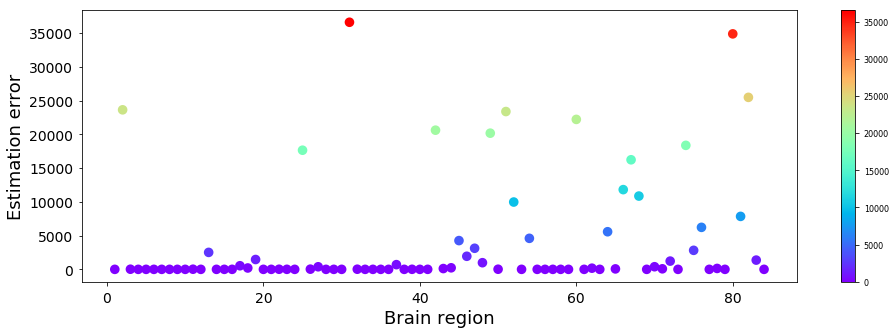

In [111]:
from matplotlib import cm

plt.figure(figsize=(16, 5))    
y=Err_per_region
colors = cm.seismic(y)
plot = plt.scatter(r_[:y.shape[0]]+1, y, c = y, cmap = 'rainbow', lw=4)
plt.colorbar(plot)
plt.xlabel("Brain region", fontsize=18)
plt.ylabel("Estimation error", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(cwd,"SourceLocalizationError.png"))
plt.show()

In [106]:
err_thr=5000

# Plot region and electrode positions

Here we compute the "contacts" from "complex.ades"

In [89]:
contacts = []
with open(cwd+ '/ExperimentalData_CJ/complex_raw.ades', 'r') as fd:
    for line in fd.readlines():
        parts = [p.strip() for p in line.strip().split('=')]
        if len(parts)>1 and parts[1] == 'SEEG':
            name, idx = re.match("([A-Z]+[a-z]*[']*)([0-9]+)", parts[0]).groups()
            idx = int(idx)
            contacts.append((name, idx)) 

Here we compute the names, and xyz positions of regions and the electrodes from "centers.txt", "elecs_name.txt", respectively, and then we plot them in (x, y),  (x,z), and (y,z) coordinates.

In [90]:
reg_xyz = np.loadtxt(cwd+ '/ExperimentalData_CJ/centers.txt', usecols=(1,2,3))
reg_names = []
with open(cwd+ '/ExperimentalData_CJ/centers.txt', 'r') as fd:
    #for line in fd.readlines():
     #   reg_names.append(line.strip().split()[0])
    for i, line in enumerate(fd.readlines()):
        reg_names.append('r%03d-%s' % (i, line.strip().split()[0]))
#seg = nibabel.load('aparcaseg_2_diff_2.nii.gz')
#reg_xyz = seg.affine.dot(c_[reg_xyz, ones((reg_xyz.shape[0], ))].T)[:3].T


seeg_labels = []
seeg_xyz = np.loadtxt(cwd+ '/ExperimentalData_CJ/elecs_name.txt', usecols=(1,2,3))
with open(cwd+ '/ExperimentalData_CJ/elecs_name.txt', 'r') as fd:
    for line in fd.readlines():
        parts = line.strip().split()
        seeg_labels.append(parts[0].upper())
#print sorted(seeg_labels+[e+str(i) for e, i in contacts])
monopolar_chan_to_pos = []
for name, idx in contacts:
    monopolar_chan_to_pos.append(seeg_labels.index(name+str(idx)))
seeg_xyz = np.array([seeg_xyz[i] for i in monopolar_chan_to_pos])

In [91]:
def plot_electrodes():
    x, y, z = zip(reg_xyz.T, seeg_xyz.T)
    for i, ((ra, sa), (rb, sb)) in enumerate([(x, y), (y, z), (z, x)]):
        plt.subplot(1, 3, i + 1)
        plt.scatter(sa, sb ,color='gray',marker='^', s=25)
        yy=Err_per_region
        colors = cm.seismic(yy)
        plt.scatter(ra,rb, cmap = 'rainbow', color=colors, s=50)
        plt.scatter(ra,rb, color=colors, s=.5e-2*yy)
#       for i in [ n for n,i in enumerate(Err_per_region) if i>err_thr ]:
#             plt.scatter(ra[i], rb[i], color='r', s=50)
        plt.axis([-120, 100, -120, 100])

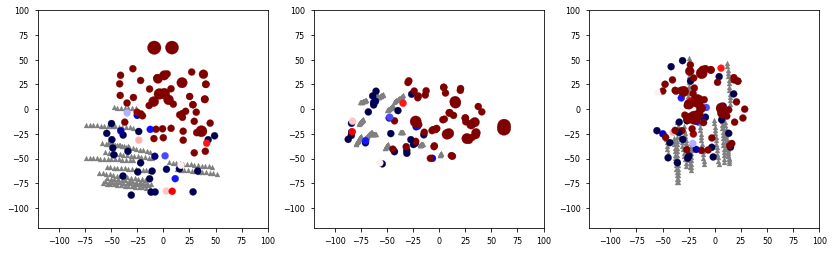

In [94]:
plt.figure(figsize=(14, 4))
plot_electrodes()
plt.savefig(os.path.join(cwd,"SensorSourcepng"))
plt.show()

In [95]:
elecnames=[]
electrodes = {}  
with open(cwd+ '/ExperimentalData_CJ/elecs_name.txt', 'r') as fd:
            for i, line in enumerate(fd.readlines()):
                line = line.strip()
                contact, x, y, z = line.split()
                elecnames.append(contact)
                name, _ = re.match("([A-Za-z]+[']*)([0-9]+)", contact).groups()
                if name in electrodes:
                    electrodes[name].append(i)
                else:
                    electrodes[name] = [i]

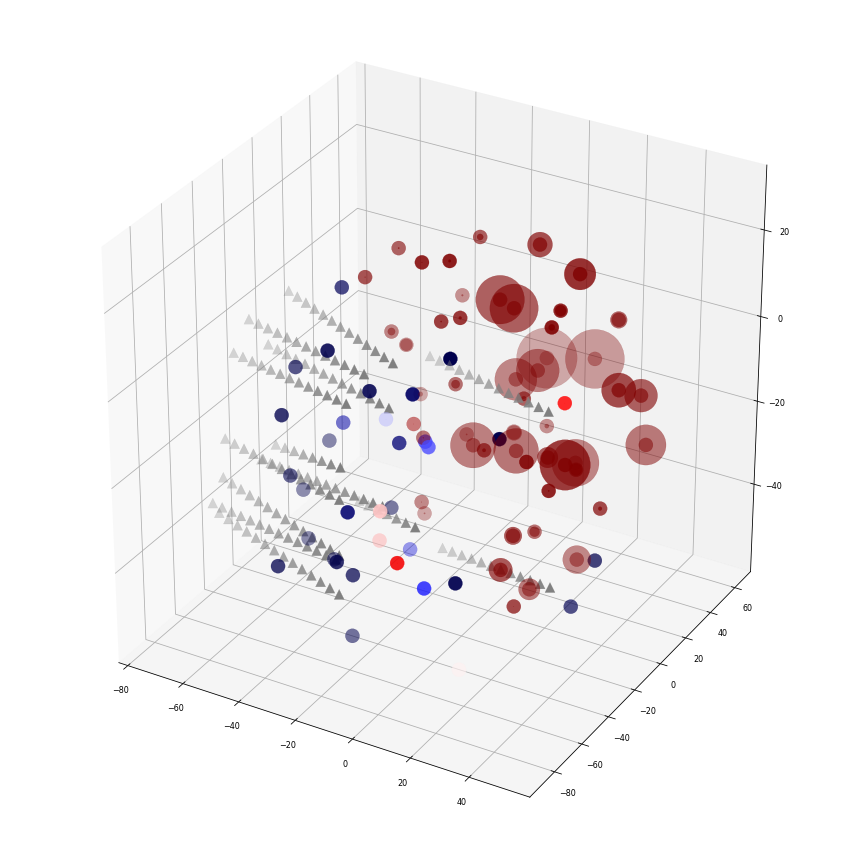

In [96]:
       
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

for name, idxs in electrodes.items():
    ax.scatter(seeg_xyz [idxs, 0], seeg_xyz [idxs, 1], seeg_xyz [idxs, 2], color='grey', marker='^', s=100)
    
y=Err_per_region
colors = cm.seismic(y)
ax.scatter(reg_xyz [:, 0], reg_xyz [:, 1], reg_xyz [:, 2], color=colors, s=200)
ax.scatter(reg_xyz [:, 0], reg_xyz [:, 1], reg_xyz [:, 2], color=colors, s=1e-1*y)

# for i in [ n for n,i in enumerate(Err_per_region) if i>err_thr ]:
#       ax.scatter(reg_xyz [i, 0], reg_xyz [i, 1], reg_xyz [i, 2], color='m', s=0.1e13*(y / float(max(y))))

#plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(cwd,"SourceLocalizationErrorperRegion.png"))

plt.show()    